In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import torchvision
from torchvision.transforms.functional import crop, resize
import matplotlib.pyplot as plt

In [2]:
img = torchvision.io.read_image("/home/gustav/Pictures/dumb-shit/teddy-chair.jpg")
#img = torch.ones(3,200,200) * 255

img_tensor = img.unsqueeze(0).to(torch.float32)
img_tensor.shape

torch.Size([1, 3, 480, 640])

In [3]:
def sparse_ones(shape, coords):
    t = torch.zeros(*shape)
    for coor in coords:
        t[coor] = 1.0

    return t

torch.Size([3, 480, 640]) tensor(0.9961)


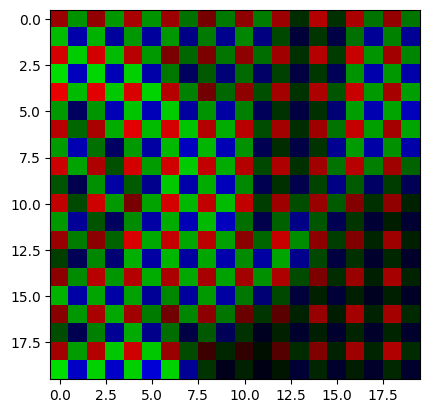

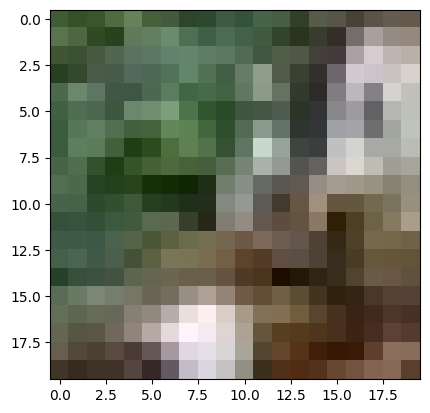

In [4]:
rgb_k = sparse_ones((4,3,2,2), [(0,0,0,0),(1,1,0,1),(2,2,1,1),(3,1,1,0)])

img_down   = F.conv2d          (img_tensor, stride=2, weight=rgb_k)
img_up     = F.conv_transpose2d(img_down,   stride=2, weight=rgb_k)
img_sensor = img_up.squeeze() * (1/256)
print(img_sensor.shape, img_sensor.max())

plt.imshow(crop(img_sensor, 400, 200, 20, 20).permute(1,2,0))
plt.show()
plt.imshow(crop(img, 100, 100, 20, 20).squeeze().permute(1,2,0))

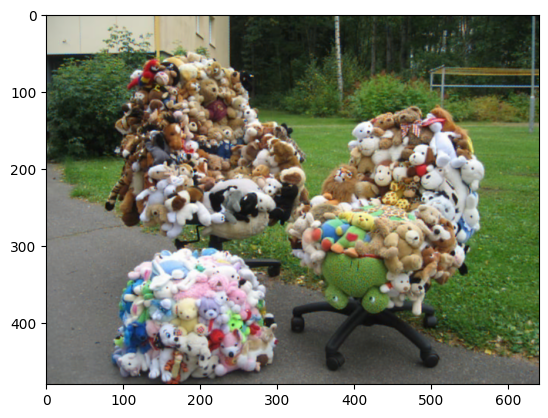

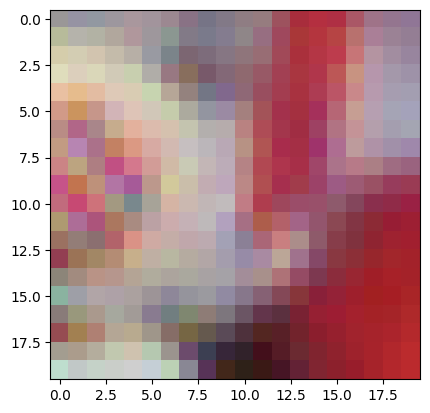

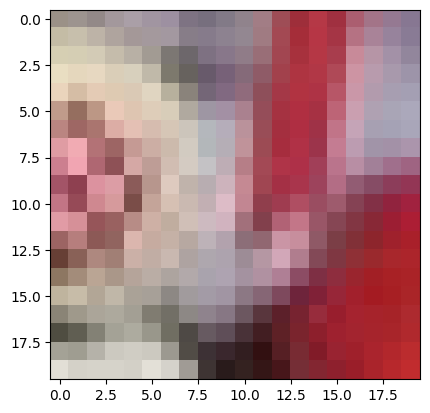

In [5]:
lin_k = sparse_ones((3,3,3,3), [(1,1,0,1), (1,1,1,0), (1,1,1,2), (1,1,2,1)]) * (1/4)
hor_k = sparse_ones((3,3,1,3), [(0,0,0,0), (0,0,0,2), (2,2,0,0), (2,2,0,2)]) * (1/2)
ver_k = hor_k.permute(0,1,3,2)

res_img = img_sensor.clone()
for pad, ker in [((1,1,0,0), hor_k), ((0,0,1,1), ver_k), ((1,1,1,1), lin_k)]:
    res_img += F.conv2d(F.pad(res_img, pad, mode="reflect"), ker)

plt.imshow(res_img.permute(1,2,0))
plt.show()
plt.imshow(crop(res_img, 400, 200, 20, 20).permute(1,2,0)) # bør bruge multiplot
plt.show()
plt.imshow(crop(img,     400, 200, 20, 20).permute(1,2,0))

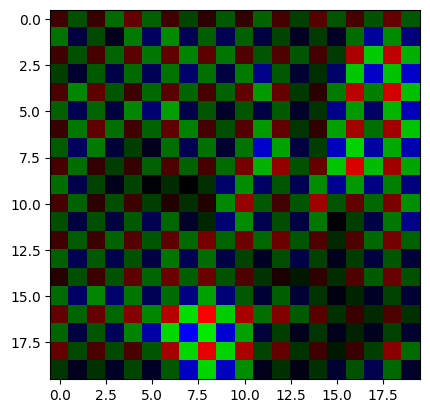

In [6]:
test_crop = crop(img_sensor, 100, 100, 20, 20).permute(1,2,0)
plt.imshow(test_crop)

In [7]:
import itertools as iter

def ahd(img):
    h, w, c = img.shape
    i_pad = F.pad(test_crop.permute(2,1,0),(1,1,1,1)).permute(1,2,0)
    g_hor = torch.zeros(h,w)
    g_ver = torch.zeros(h,w)
    
    for x in range(1,w,2):
        for y in range(0,w):
            print(i_pad[x + y % 2 + 1, y + 1, 1])

ahd(test_crop)

tensor(0.3164)
tensor(0.2891)
tensor(0.3164)
tensor(0.3555)
tensor(0.5273)
tensor(0.3984)
tensor(0.4688)
tensor(0.4805)
tensor(0.4297)
tensor(0.2656)
tensor(0.3828)
tensor(0.3125)
tensor(0.3555)
tensor(0.3477)
tensor(0.3086)
tensor(0.5273)
tensor(0.3984)
tensor(0.3398)
tensor(0.2852)
tensor(0.1953)
tensor(0.4219)
tensor(0.4766)
tensor(0.3945)
tensor(0.4141)
tensor(0.3398)
tensor(0.5273)
tensor(0.4336)
tensor(0.2461)
tensor(0.2422)
tensor(0.2656)
tensor(0.3086)
tensor(0.3516)
tensor(0.3867)
tensor(0.3164)
tensor(0.3242)
tensor(0.4609)
tensor(0.4062)
tensor(0.5156)
tensor(0.2891)
tensor(0.2695)
tensor(0.3750)
tensor(0.5430)
tensor(0.4688)
tensor(0.4492)
tensor(0.4102)
tensor(0.6211)
tensor(0.3867)
tensor(0.4336)
tensor(0.3789)
tensor(0.1680)
tensor(0.2461)
tensor(0.4062)
tensor(0.3398)
tensor(0.4609)
tensor(0.3945)
tensor(0.4219)
tensor(0.5312)
tensor(0.8477)
tensor(0.3398)
tensor(0.3477)
tensor(0.2695)
tensor(0.3711)
tensor(0.5195)
tensor(0.4453)
tensor(0.3984)
tensor(0.3320)
tensor(0.5

In [8]:
import numpy as np

res = np.zeros((8,8))
res[2, :] = 1
res[5, :] = 1
res = res.T
F.conv2d(torch.Tensor(res).unsqueeze(0), weight=torch.Tensor([[[-0.5, 1,1,1, -0.5]]]))

RuntimeError: expected stride to be a single integer value or a list of 1 values to match the convolution dimensions, but got stride=[1, 1]

In [34]:
from PIL import Image
import cfa
import noise
import numpy as np

fig_img   = np.array(crop(img,     400, 200, 20, 20).permute(1,2,0))
fig_noise = noise.salt_pepper_noise(fig_img)
fig_cfa   = cfa.colorize_cfa(cfa.rgb_to_cfa(fig_noise, cfa.rgb_kf), cfa.rgb_kf).astype(np.uint8)

res_img   = torch.Tensor(fig_cfa).to(dtype=torch.float32).permute(2,0,1)
for pad, ker in [((1,1,0,0), hor_k), ((0,0,1,1), ver_k), ((1,1,1,1), lin_k)]:
    res_img += F.conv2d(F.pad(res_img, pad, mode="reflect"), ker)

fig_bil  = np.array(res_img.permute(2,1,0), np.uint8)
fig_n1   = noise.gaussian_noise(fig_img, scale=.04)
fig_n2   = noise.gaussian_noise(fig_img, scale=.07, seed=[8])
display(Image.fromarray(fig_n1))
display(Image.fromarray(fig_n2))